In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as pd
import itertools
from pygem_eb.processing.plotting_fxns import *
from objectives import *
data_fp = '/home/claire/research/MB_data/Gulkana/Input_Gulkana_Glaciological_Data.csv'

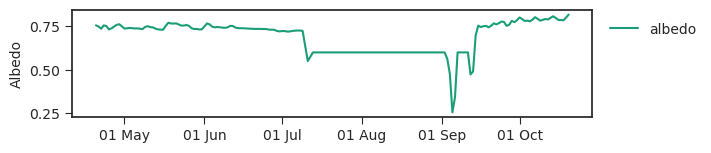

In [8]:
# PLOT A SINGLE RUN
path_out = '/home/claire/research/Output/calibration/09_23/'
kw = 0.5
k_snow = 'Douville'
a_ice = 0.2
site = 'D'
fn = f'kw{kw}_ksnow{k_snow}_aice{a_ice}_site{site}_0.nc'
ds,startdate,enddate = getds(path_out+fn)
# winter,summer = seasonal_mass_balance(data_fp,ds,site)
simple_plot(ds,['2004-04-20','2004-10-20'],[['albedo']],res='d')

In [233]:
# summer_result_all = [summer_result][0]
# winter_result_all = [winter_result][0]

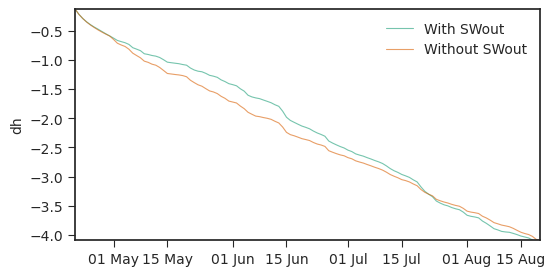

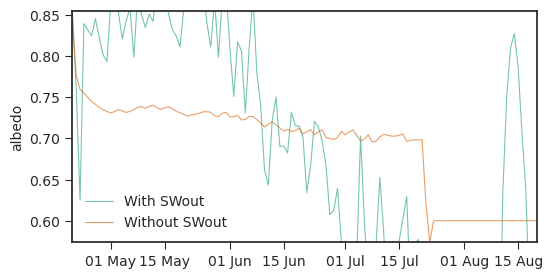

In [19]:
ds0,startdate,enddate = getds('/home/claire/research/Output/EB/Gulkana_2024_09_26_0.nc')
ds1,startdate,enddate = getds('/home/claire/research/Output/EB/Gulkana_2024_09_26_1.nc')
compare_runs([ds0,ds1],[startdate,enddate],['With SWout','Without SWout'],'dh')
compare_runs([ds0,ds1],[startdate,enddate],['With SWout','Without SWout'],'albedo')

In [234]:
path_out = '/home/claire/research/Output/calibration/09_24/'

# Parameter sets
aa = [0.2,0.4,0.6]
ww = [0.25,0.5,0.75,1]
kk = ['Sturm','Douville','Jansson'] #,'OstinAndersson','VanDusen']
params_dict = {'kw':ww,'k_snow':kk,'a_ice':aa} # 'kw':ww,

# Get the lengths of each parameter list for the result array shape
shape = [len(v) for v in params_dict.values()]

# Initialize result arrays with a dimension for site (3 sites + 1 for the average)
winter_result = np.ones([4] + shape)
summer_result = np.ones([4] + shape)

# Initialize lists for storing the parameters
params_list = {key: [] for key in params_dict}

# Generate combinations of all parameters
all_combos = itertools.product(*params_dict.values())
for idx, param_values in enumerate(all_combos):
    # Unpack indices
    indices = np.unravel_index(idx, shape)

    # Store parameter set
    for param_name, param_value in zip(params_dict.keys(), param_values):
        params_list[param_name].append(param_value)
    
    # Iterate over sites
    for s, site in enumerate(['AB', 'B', 'D']):
        kw = 0.25 if site == 'D' else 1
        fn = f'kw{kw}_'

        # fn = ''
        for param_name, param_value in zip(params_dict.keys(), param_values):
            fn += param_name.replace('_','')+str(param_value)+'_'
        fn += f'site{site}_0.nc'

        try:
            ds, startdate, enddate = getds(path_out + fn)
            winter, summer = seasonal_mass_balance(data_fp, ds, site=site, method='MAE')
        except:
            winter, summer = (np.nan, np.nan)
            print(fn + ' does not exist')
        
        # Store results in the corresponding array
        winter_result[s][indices] = winter
        summer_result[s][indices] = summer

    # Compute site averages and store in the last index (3rd index in the result arrays)
    winter_result[3][indices] = np.mean(winter_result[:3,*indices])
    summer_result[3][indices] = np.mean(summer_result[:3,*indices])

In [235]:
best = {'winter': {key: [] for key in params_dict}, 
        'summer': {key: [] for key in params_dict}}

if summer_result.shape == (4,4,3,3):
    print('When including kw as a parameter:')
elif summer_result.shape == (4,3,3):
    print('When setting kw = 0.25 at site D, 1 elsewhere:')
for site in ['mean','AB','B','D','mean']:
    idx = np.where(np.array(['AB','B','D','mean']) == site)[0]
    best_winter = np.argmin(winter_result[idx])
    best_summer = np.argmin(summer_result[idx])
    for key in params_dict:
        best['winter'][key] = params_list[key][best_winter]
        best['summer'][key] = params_list[key][best_summer]
    if site == 'mean':
        print('Best winter parameter set overall:',best['winter'])
        print('Best summer parameter set overall:',best['summer'])
        print()
    else:
        print(f'Best winter parameter set at site {site}:',best['winter'])
        print(f'Best summer parameter set at site {site}:',best['summer'])

When setting kw = 0.25 at site D, 1 elsewhere:
Best winter parameter set overall: {'k_snow': 'Sturm', 'a_ice': 0.6}
Best summer parameter set overall: {'k_snow': 'Jansson', 'a_ice': 0.6}

Best winter parameter set at site AB: {'k_snow': 'Jansson', 'a_ice': 0.4}
Best summer parameter set at site AB: {'k_snow': 'Jansson', 'a_ice': 0.2}
Best winter parameter set at site B: {'k_snow': 'Sturm', 'a_ice': 0.6}
Best summer parameter set at site B: {'k_snow': 'Jansson', 'a_ice': 0.6}
Best winter parameter set at site D: {'k_snow': 'Sturm', 'a_ice': 0.6}
Best summer parameter set at site D: {'k_snow': 'Sturm', 'a_ice': 0.2}
Best winter parameter set overall: {'k_snow': 'Sturm', 'a_ice': 0.6}
Best summer parameter set overall: {'k_snow': 'Jansson', 'a_ice': 0.6}



In [237]:
# MAKE PLOTS OF BEST MODEL RUNS
# for season in ['summer','winter']:
#     # kw = best[season]['kw']
#     k_snow = best[season]['k_snow']
#     a_ice = best[season]['a_ice']

#     for site in ['AB','B','D']:
#         kw = 0.25 if site == 'D' else 1
#         fn = f'kw{kw}_ksnow{k_snow}_aice{a_ice}_site{site}_0.nc'
#         param_set = '$k_{snow}$: KSNOW    $a_{ice}$: AICE     $k_w$: KW'
#         param_set = param_set.replace('KSNOW',str(k_snow))
#         param_set = param_set.replace('AICE',str(a_ice))
#         param_set = param_set.replace('KW',str(kw))
#         ds = xr.open_dataset(path_out + fn)
#         fig,ax = seasonal_mass_balance(data_fp,ds,site,plot=True)
#         fig.suptitle(f'Best overall {season} parameter set at site {site}\n{param_set}',y=1.03,fontsize=14)
#         plt.savefig(f'/home/claire/research/Output/Figs/best_{site}_{season}.png',dpi=150,bbox_inches='tight')
#         plt.show()

In [238]:
def grid_plot(params_dict,summer_result,winter_result):
    """
    Parameters
    ----------
    params_dict : dict
        dict formatted as 'param_name':[option_1,option_2,...]
    result_summer and reuslt_winter : np.array
        should be size (N1xN2x...Nn) where:
            n is the number of param sets
            N is the number of options in each set
    """
    # Parse parameters
    param_names = list(params_dict.keys())
    combos = list(itertools.combinations(param_names,2))
    n_combos = len(combos)
    mid_idx = n_combos / 2
    if mid_idx % 1 != 0:
        mid_idx = int(mid_idx)

    # Create plot
    fig = plt.figure(figsize=(3*n_combos, 5))
    ratios = np.append(np.array([1]*n_combos).flatten(),0.3)
    gs = fig.add_gridspec(2,n_combos+1, wspace=1,hspace=0.5, width_ratios=ratios)

    # Normalize loss values across all three plots for shared colorbar
    all_summer = summer_result[~np.isnan(summer_result)].flatten()
    all_winter = winter_result[~np.isnan(winter_result)].flatten()
    norm_summer = plt.Normalize(vmin=np.min(all_summer), vmax=np.max(all_summer))
    norm_winter = plt.Normalize(vmin=np.min(all_winter), vmax=np.max(all_winter))
    cmap = 'viridis_r'

    # Create the scatter plots
    for j,pair in enumerate(combos):
        # Unpack the parameters
        param_1 = params_dict[pair[0]]
        param_2 = params_dict[pair[1]]

        # If parameter is a string, need to parse differently
        ylabels = False
        xlabels = False
        if type(param_1[0]) == str:
            xlabels = param_1
            param_1 = np.arange(len(param_1))
        if type(param_2[0]) == str:
            ylabels = param_2
            param_2 = np.arange(len(param_2))
        
        # Create meshgrid
        x,y = np.meshgrid(param_1,param_2)
        for i,season in enumerate(['winter','summer']):
            ax = fig.add_subplot(gs[i,j])
    
            if n_combos > 1:
                slices = [slice(None)] * n_combos
                slices[np.flip(np.arange(len(combos)))[j]] = mid_idx
                if season == 'summer':
                    result = summer_result[tuple(slices)]
                    norm = norm_summer
                elif season == 'winter':
                    result = winter_result[tuple(slices)]
                    norm = norm_winter
            else:
                if season == 'summer':
                    result = summer_result
                    norm = norm_summer
                elif season == 'winter':
                    result = winter_result
                    norm = norm_winter

            ax.scatter(x,y,c=result.T,cmap=cmap,s=500,norm=norm)
            ax.set_xlabel(pair[0],fontsize=12)
            ax.set_ylabel(pair[1],fontsize=12)
            ax.set_xticks(param_1)
            ax.set_yticks(param_2)
            ax.grid(True)
            if type(xlabels) != bool:
                ax.set_xticklabels(xlabels)
            if type(ylabels) != bool:
                ax.set_yticklabels(ylabels)

    # Add colorbars to each row
    cax1 = fig.add_subplot(gs[0,n_combos])
    cax2 = fig.add_subplot(gs[1,n_combos])
    axes = np.array(fig.get_axes()).reshape(2,n_combos+1)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_winter, cmap=cmap),ax=axes[0,:-1], orientation='vertical',cax=cax1)
    cbar.set_label('Winter MAE',loc='top',fontsize=12)

    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_summer, cmap=cmap), ax=axes[1,:-1], orientation='vertical',cax=cax2)
    cbar.set_label('Summer MAE',loc='top',fontsize=12)
    return fig, axes

In [241]:
# # summer_result_not = [summer_result][0]
# # winter_result_not = [winter_result][0]
# summer_result = summer_result_all
# winter_result = winter_result_all

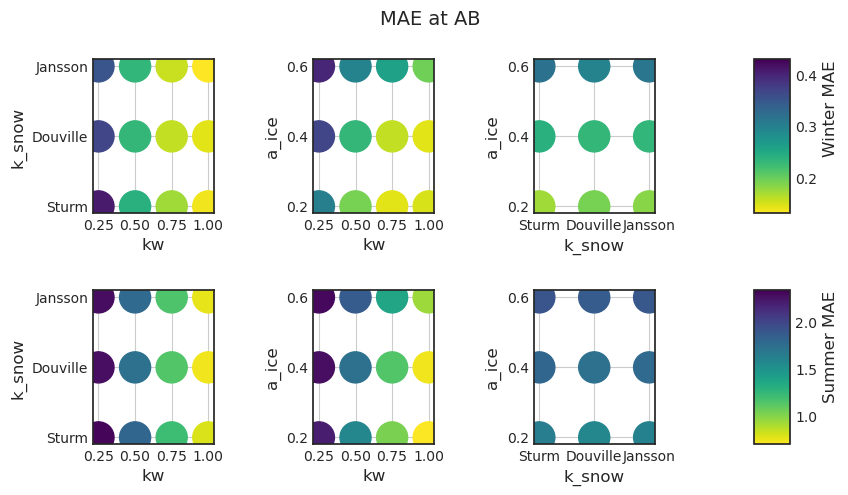

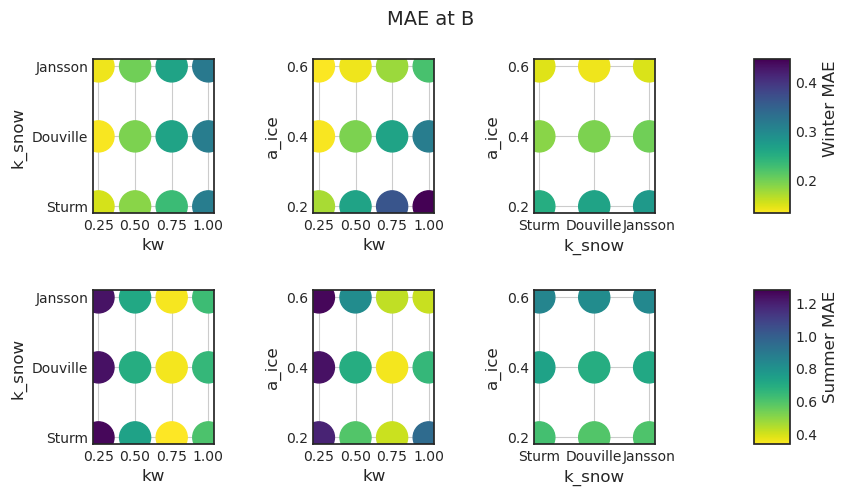

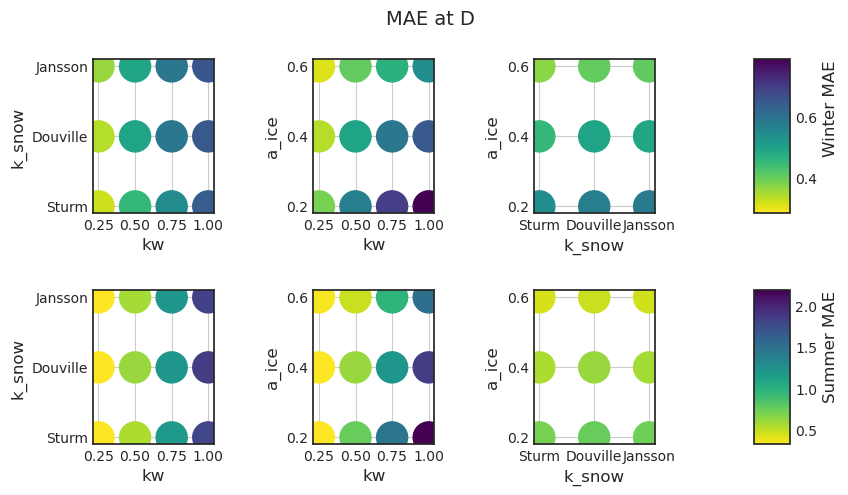

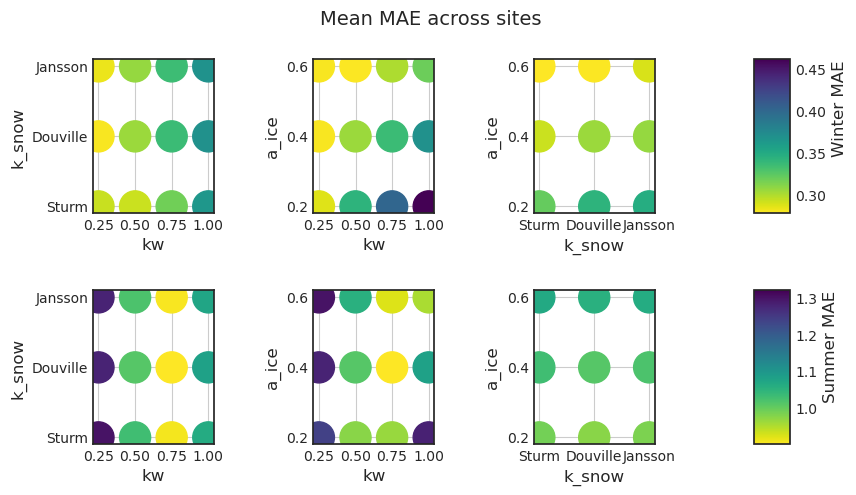

In [243]:
for site in ['AB','B','D','mean']:
    idx = np.where(np.array(['AB','B','D','mean']) == site)[0][0]
    fig, axes = grid_plot(params_dict,summer_result[idx],winter_result[idx])
    if site == 'mean':
        title_first = f'Mean MAE across sites'
    else:
        title_first = f'MAE at {site}'
    if summer_result.shape == (4,4,3,3):
        fig.suptitle(title_first,fontsize=14)
        plt.savefig(f'/home/claire/research/Output/Figs/grid_plot_{site}.png',dpi=200,bbox_inches='tight')
    elif summer_result.shape == (4,3,3):
        fig.suptitle(f'{title_first}\nWith kw=0.25 at D and 1 elsewhere',fontsize=14)
        plt.savefig(f'/home/claire/research/Output/Figs/grid_plot_{site}_nokw.png',dpi=200,bbox_inches='tight')

In [171]:
def check(kw,k_snow,a_ice,site,season):
    if site == 'mean':
        looplist = ['AB','B','D']
    else:
        looplist = [site]
    result = []
    for site in looplist:
        fn = path_out + f'kw{kw}_ksnow{k_snow}_aice{a_ice}_site{site}_0.nc'
        ds = xr.open_dataset(fn)
        winter,summer = seasonal_mass_balance(data_fp,ds,site)
        if season == 'winter':
            result.append(winter)
        else:
            result.append(summer)
    return np.mean(result)

In [76]:
def plot_by(ds,time,vars,t='Monthly EB Outputs',by='month'):
    h = 1.5
    fig,axes = plt.subplots(len(vars),1,figsize=(7,h*len(vars)),sharex=True,layout='constrained')
    if len(vars) == 1:
        axes = [axes]
    
    if by == 'month':
        ds[by] = (['time'],pd.to_datetime(ds['time'].values).month)
        time_list = np.arange(1,13)
    elif by == 'hour':
        ds[by] = (['time'],pd.to_datetime(ds['time'].values).hour)
        time_list = np.arange(0,24)
    elif by == 'doy':
        ds[by] = (['time'],pd.to_datetime(ds['time'].values).day_of_year)
        time_list = np.arange(1,366)
        running_sum = 0

    if len(time) == 2:
        start = pd.to_datetime(time[0])
        end = pd.to_datetime(time[1])
        time = pd.date_range(start,end,freq='h')
    ds = ds.sel(time=time)
    c_iter = iter([plt.cm.Dark2(i) for i in range(8)])
    for i,v in enumerate(vars):
        axis = axes[i]
        vararray = np.array(v)
        for var in vararray:
            try:
                c = next(c_iter)
            except:
                c_iter = iter([plt.cm.Dark2(i) for i in range(8)])
                c = next(c_iter)
        
            var_out = []
            for time in time_list:
                ds_sel = ds.where(ds[by] == time,drop=True)
                if 'layer' in var:
                    vardata = ds_sel.isel(layer=0)[var].to_numpy()
                else:
                    vardata = ds_sel[var].to_numpy()
                if by == 'doy':
                    nyrs = int(vardata.shape[0] / 24)
                    try:
                        vardata = np.mean(vardata.reshape(24,nyrs),axis=0)
                    except:
                        if time != 366:
                            print('Must index dates exactly 1 year - 1 day apart')
                        vardata = np.array([0])
                    out = np.mean(vardata)
                else:
                    out = np.mean(vardata)
                var_out.append(out)
            axis.plot(time_list,var_out,label=var,color=c)
            axis.legend()
            if by == 'doy':
                axis.axvline(111,color='green')
                axis.axvline(294,color='red')
    if by == 'month':
        months = pd.date_range('2024-01-01','2024-12-31',freq='MS')
        month_names = [date.month_name()[:3] for date in months]
        axis.set_xticks(np.arange(1,13),month_names)
    if by == 'doy':
        axis.set_xlabel('Day of year')
    axis.set_ylabel('Melt (mm w.e.)')
    axis.tick_params(length=5)
    fig.suptitle(t)

Must index dates exactly 1 year - 1 day apart


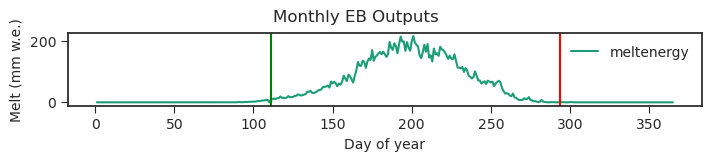

In [85]:
ds = xr.open_dataset('/home/claire/research/Output/calibration/09_18/ksnowDouville_aice0.4_siteAB_0.nc')
ds.melt.values *= 1000
plot_by(ds,[startdate,'2022-04-20'],[['meltenergy']],by='doy')